In [1]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_scraped = pd.read_csv('filtered_hotel_reviews_all.csv')

In [3]:
all_scraped = all_scraped.replace(np.nan, '', regex=True)
all_scraped = all_scraped.drop('Unnamed: 0', axis=1)
all_scraped = all_scraped[all_scraped['Combined comment'].map(lambda x: x.isascii())]
all_scraped = all_scraped[all_scraped['Score'] != '']
all_scraped.loc[all_scraped['Score'] < 6, 'Score'] = 6
all_scraped['Score'] = round(all_scraped['Score'].astype(float)) - 6

In [4]:
tripadvisor = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [5]:
tripadvisor = tripadvisor.rename(columns={"Review": "Combined comment", "Rating": "Score"})

In [6]:
tripadvisor['Score'] = tripadvisor['Score'] - 1

In [7]:
merged_train = all_scraped.append(tripadvisor)
merged_train

,Combined comment,Disliked,Hotel,Liked,Score
0,The breakfast was nice and it is located close...,The beds were REALLY uncomfortable. .The front...,Salena Beach Hotel,The breakfast was nice and it is located close...,0.0
1,Big nice pool.Tasty breakfast.Close to the bea...,"There is no hotel parking, you will find free ...",Salena Beach Hotel,Big nice pool.Tasty breakfast.Close to the bea...,1.0
2,Pool. .Location.. Nobody cleaned our room for ...,Nobody cleaned our room for 5 days of our vaca...,Salena Beach Hotel,Pool. .Location..,0.0
3,"Breakfast was very poor, for the 5 days, we ha...","The room was extremely dirty, bathroom was ful...",Salena Beach Hotel,"Breakfast was very poor, for the 5 days, we ha...",0.0
4,Huge disappointment!! .The hotel is very dirt...,Huge disappointment!! .The hotel is very dirty...,Salena Beach Hotel,,0.0
...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",NaN,NaN,NaN,4.0
20487,great location price view hotel great quick pl...,NaN,NaN,NaN,3.0
20488,"ok just looks nice modern outside, desk staff ...",NaN,NaN,NaN,1.0
20489,hotel theft ruined vacation hotel opened sept ...,NaN,NaN,NaN,0.0


In [8]:
def remove_punctuation(input_str):
    punctuation= '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    emptyString=" "
    for x in punctuation:
        input_str=input_str.replace(x,emptyString)
        
    input_str = ' '.join(input_str.split())
    return input_str

In [9]:
merged_train['Combined comment'] = merged_train['Combined comment'].apply(remove_punctuation)

In [10]:
class_count = merged_train['Score'].value_counts()
class_count

4.0    22681
3.0    14215
2.0     7835
0.0     5715
1.0     5286
Name: Score, dtype: int64

/home/kdimitrov/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number of reviews ')

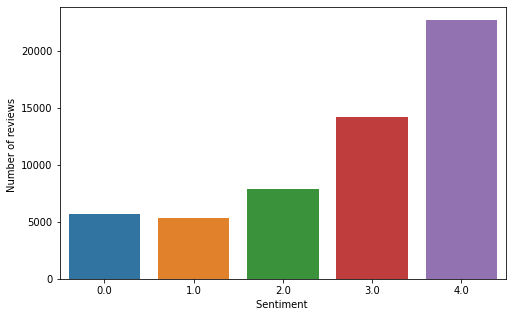

In [11]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

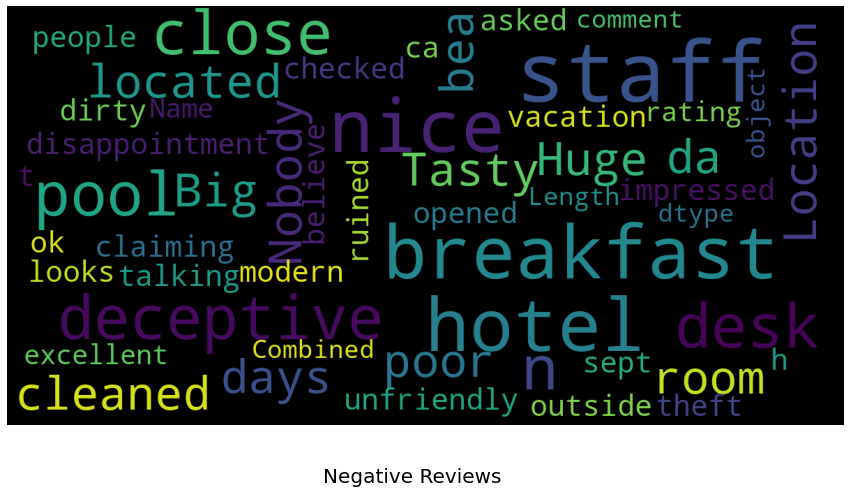

In [13]:
show_wordcloud(merged_train[merged_train['Score'] < 2]['Combined comment'],'Negative Reviews')

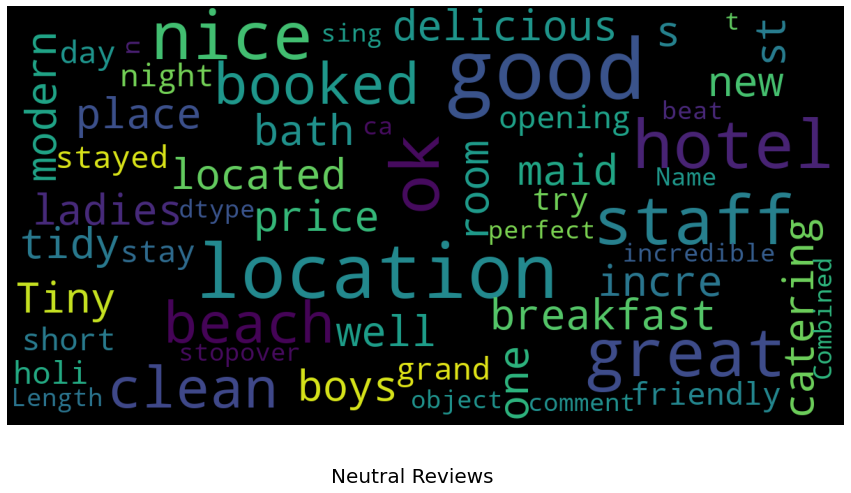

In [14]:
show_wordcloud(merged_train[merged_train['Score'] == 2]['Combined comment'],'Neutral Reviews')

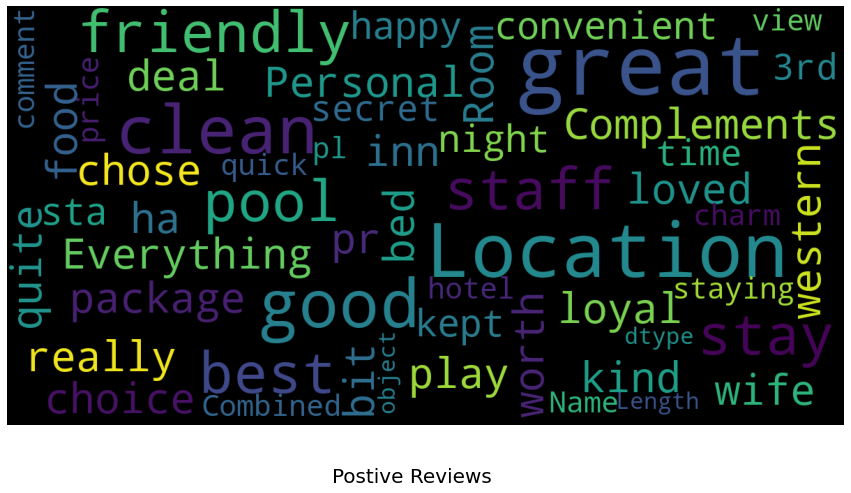

In [15]:
show_wordcloud(merged_train[merged_train['Score'] > 2]['Combined comment'],'Postive Reviews')

In [16]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize, stop_words=set(STOPWORDS))
full_text = list(merged_train['Combined comment'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(merged_train['Combined comment'])

/home/kdimitrov/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
y = merged_train['Score']
y=y.astype('int')

In [19]:
from sklearn.model_selection import train_test_split
x_train , x_val, y_train , y_val = train_test_split(train_vectorized,y,test_size = 0.2)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train,y_train)
print(classification_report( ovr.predict(x_val) , y_val))
print(accuracy_score( ovr.predict(x_val) , y_val ))

/home/kdimitrov/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.53      0.59      0.56      1055
           1       0.02      0.35      0.04        72
           2       0.05      0.26      0.08       311
           3       0.28      0.34      0.31      2392
           4       0.90      0.55      0.69      7317

    accuracy                           0.50     11147
   macro avg       0.36      0.42      0.34     11147
weighted avg       0.71      0.50      0.57     11147

0.5013905086570377


In [22]:
manual_test = vectorizer.transform(['Good location, nice staff, good facilities with ski hire and frequent drop offs to gondola. Clean rooms and lobby and the breakfast is good. Walls are very thin, you can almost hear conversations in the rooms next to you. We were next to a group of partying students on our first night but the hotel thankfully let us move rooms.'])

In [23]:
ovr.predict(manual_test)

array([3])